In [ ]:
!pip install torch-dreams --upgrade

In [48]:
import os
import matplotlib.pyplot as plt
import torchvision.models as models 
from torch_dreams.dreamer import dreamer

import numpy as np

In [23]:
model = models.resnet18(pretrained=True)
dreamy_boi = dreamer(model)

layer = model.fc
layers_to_use = [layer]  ## feel free to add more layers

dreamer init on:  cuda


In [24]:
categories = {
    "goldfish": 1,
    "zebra": 340,
    "baloon": 417
}

In [ ]:
# os.system("wget https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/sample_small.jpg")

resnet_optims = []
for index in list(categories.values()):

    def optimize_1_logit(layer_outputs):
        """
        You can alter this function to use as many layers as you want
        Just make sure you also include them in the layers argument
        """
        loss = layer_outputs[0][index]

        return loss

    out_single_layer = dreamy_boi.deep_dream(
        image_path = "noise.jpg",
        layers = layers_to_use,
        octave_scale = 1.3,
        num_octaves = 10,
        iterations = 200,
        lr = 0.9,
        custom_func = optimize_1_logit
    )
    resnet_optims.append(out_single_layer)

    # plt.imshow(out_single_layer)
    # plt.show()

In [29]:
model = models.alexnet(pretrained=True)
dreamy_boi = dreamer(model)

vgg_last_layer = model.classifier[-1]
layers_to_use = [vgg_last_layer]  ## feel free to add more layers

dreamer init on:  cuda


In [ ]:
os.system("wget https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/noise.jpg")

alex_optims = []
for index in list(categories.values()):

    def optimize_1_logit(layer_outputs):
        """
        You can alter this function to use as many layers as you want
        Just make sure you also include them in the layers argument
        """
        loss = layer_outputs[0][index]

        return loss

    out_single_layer = dreamy_boi.deep_dream(
        image_path = "noise.jpg",
        layers = layers_to_use,
        octave_scale = 1.3,
        num_octaves = 7,
        iterations = 200,
        lr = 0.9,
        custom_func = optimize_1_logit
    )
    alex_optims.append(out_single_layer)

    # plt.imshow(out_single_layer)
    # plt.show()

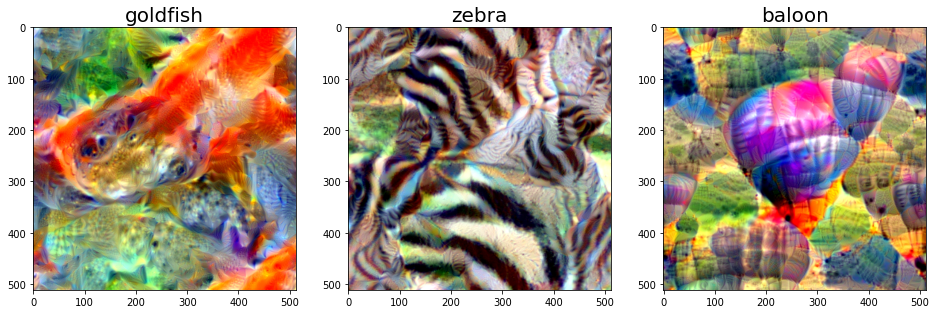

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16,8))

for i in range(len(resnet_optims)):
    ax.flat[i].imshow(resnet_optims[i])
    title = list(categories.keys())[i]
    ax.flat[i].set_title(title, fontsize = 20)


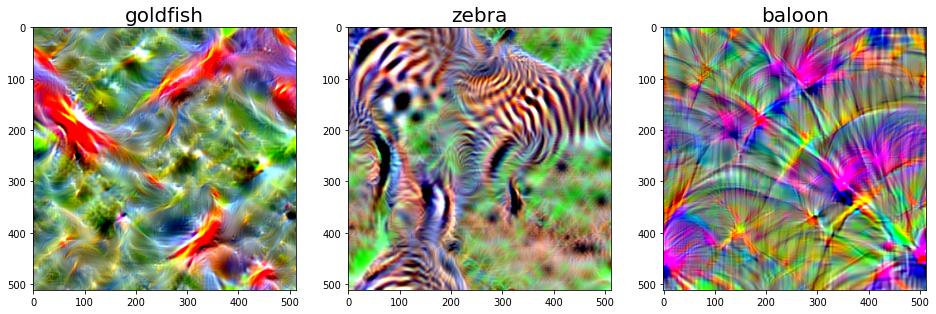

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16,8))

for i in range(len(alex_optims)):
    ax.flat[i].imshow(alex_optims[i])
    title = list(categories.keys())[i]
    ax.flat[i].set_title(title, fontsize = 20)


## Blend on resnet

In [36]:
model = models.resnet18(pretrained=True)
dreamy_boi = dreamer(model)

layer = model.fc
layers_to_use = [layer]  ## feel free to add more layers

dreamer init on:  cuda


In [ ]:
def optimize_2_layers(layer_outputs):
    """
    You can alter this function to use as many layers as you want
    Just make sure you also include them in the layers argument
    """
    loss = (layer_outputs[0][categories["zebra"]]  + layer_outputs[0][categories["goldfish"]])
    
    return loss

out_layer_blend = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,   ## the outputs of these layers would be passed into the custom_func
    octave_scale = 1.3,
    num_octaves = 10,
    iterations = 200,
    lr = 0.9,
    custom_func = optimize_2_layers
)


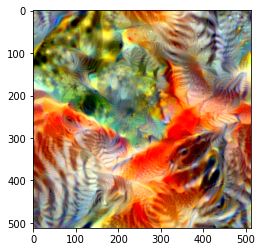

In [44]:
plt.imshow(out_layer_blend)

## interpolation between zebra and goldfish

In [55]:
cherry_picked_indices = list(categories.values())
cherry_picked_indices

[1, 340, 417]

In [ ]:
alphas = np.linspace(0, 1, 10)
print(alphas)
# all_channel_activations = []
for i in range(len(cherry_picked_indices)-1):

    for alpha in alphas:
        print("alpha : ", alpha)
        def my_custom_func(layer_outputs):
            loss = layer_outputs[0][cherry_picked_indices[i]]*(1-alpha) +layer_outputs[0][cherry_picked_indices[i+1]]*(alpha)
            return loss

        out = dreamy_boi.deep_dream(
            image_path = "noise.jpg",
            layers = layers_to_use,
            octave_scale = 1.3,
            num_octaves = 10,
            iterations = 200,
            lr = 0.9,
            custom_func =  my_custom_func,
            # max_rotation =  0.3
        )
        all_channel_activations.append(out)
        plt.imshow(out)
        plt.show()

In [60]:
len(all_channel_activations)

30

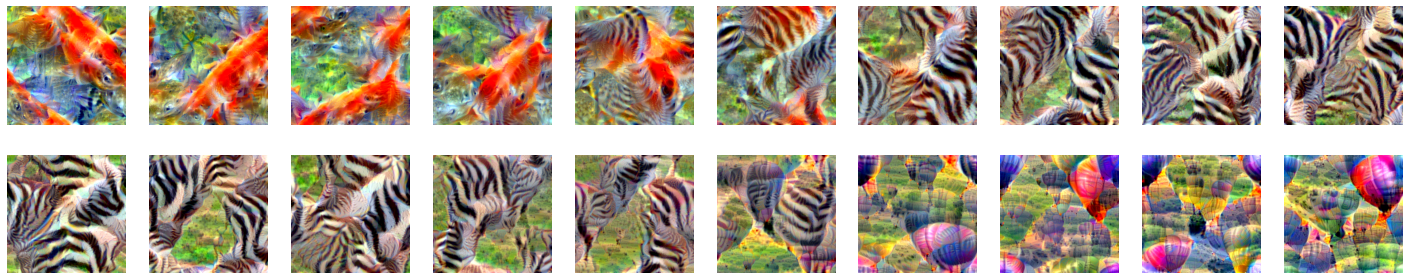

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize = (25,5))

for i in range(len(all_channel_activations)):
    # print(alphas[i])
    # title = "alpha: " + str(round(1 - alphas[i%len(alphas)], 2)) + "  beta: " + str(round(alphas[i%len(alphas)],2))
    ax.flat[i].imshow(all_channel_activations[i])
    # ax.flat[i].set_title(title, fontsize = 5)
    ax.flat[i].axis("off")
fig.savefig("resnet18_goldfish_zebra_baloon_interp.jpg")

In [94]:
!rm -rf resnet_interp_goldfish_zebra_baloon
!mkdir resnet_interp_goldfish_zebra_baloon

In [95]:
import cv2
foldername = "resnet_interp_goldfish_zebra_baloon"
names = [
         foldername + "/" + str(i) + ".jpg" for i in range(20)
]

In [96]:
for i in range(len(names)):
    cv2.imwrite(names[i], cv2.cvtColor(all_channel_activations[i], cv2.COLOR_BGR2RGB)*255)

In [ ]:
!zip -r interp_resnet.zip resnet_interp_goldfish_zebra_baloon